In [1]:
import copy
import time
from collections import defaultdict
from memory_profiler import memory_usage
import math
from math import ceil
from collections import defaultdict
import tracemalloc
import os, sys
import functools
print = functools.partial(print, flush=True)

In [2]:
def load_data(file_path):
    """
    Load data from file where:
    - -1 separates events
    - -2 separates sequences
    - Other numbers are event IDs
    """
    sequences = []
    current_sequence = []
    current_event = set()
    
    with open(file_path, 'r') as f:
        for line in f:
            tokens = line.strip().split()
            for token in tokens:
                try:
                    num = int(token)
                    if num == -2:  # End of sequence
                        if current_event:
                            current_sequence.append(sorted(current_event))
                            current_event = set()
                        if current_sequence:
                            sequences.append(current_sequence)
                            current_sequence = []
                    elif num == -1:  # End of event
                        if current_event:
                            current_sequence.append(sorted(current_event))
                            current_event = set()
                    else:  # Event ID
                        current_event.add(num)
                except ValueError:
                    # Skip non-integer tokens
                    continue
            
            # Handle end of line (treat as end of sequence)
            if current_event:
                current_sequence.append(sorted(current_event))
                current_event = set()
            if current_sequence:
                sequences.append(current_sequence)
                current_sequence = []
    
    return sequences

# Generalized Sequential Pattern Mining (GSP)

In [3]:

def is_subsequence(main_sequence, subsequence):
    """Check if subsequence is contained in main_sequence"""
    def is_subsequence_recursive(subsequence_clone, start=0):
        if not subsequence_clone:
            return True
        first_elem = set(subsequence_clone.pop(0))
        for i in range(start, len(main_sequence)):
            if set(main_sequence[i]).issuperset(first_elem):
                return is_subsequence_recursive(subsequence_clone, i + 1)
        return False
    return is_subsequence_recursive(copy.deepcopy(subsequence))

def sequence_length(sequence):
    """Calculate the total number of items in the sequence"""
    return sum(len(i) for i in sequence)

def count_support(file_path, cand_seq):
    """Count how many sequences contain the candidate sequence"""
    sequences = load_data(file_path)
    return sum(1 for seq in sequences if is_subsequence(seq, cand_seq))

def gen_cands_for_pair(cand1, cand2):
    """Generate a new candidate from two candidates of length k-1"""
    cand1_clone = copy.deepcopy(cand1)
    cand2_clone = copy.deepcopy(cand2)
    
    if len(cand1[0]) == 1:
        cand1_clone.pop(0)
    else:
        cand1_clone[0] = cand1_clone[0][1:]
        
    if len(cand2[-1]) == 1:
        cand2_clone.pop(-1)
    else:
        cand2_clone[-1] = cand2_clone[-1][:-1]
        
    if not cand1_clone == cand2_clone:
        return []
    else:
        new_cand = copy.deepcopy(cand1)
        if len(cand2[-1]) == 1:
            new_cand.append(cand2[-1])
        else:
            new_cand[-1].extend([cand2[-1][-1]])
        return new_cand

def gen_cands(last_lvl_cands):
    """Generate candidate sequences of length k+1 from frequent sequences of length k"""
    k = sequence_length(last_lvl_cands[0]) + 1
    
    if k == 2:
        flat_short_cands = [item for sublist2 in last_lvl_cands 
                          for sublist1 in sublist2 
                          for item in sublist1]
        result = [[[a, b]] for a in flat_short_cands 
                          for b in flat_short_cands 
                          if b > a]
        result.extend([[[a], [b]] for a in flat_short_cands 
                                     for b in flat_short_cands])
        return result
    else:
        cands = []
        for i in range(len(last_lvl_cands)):
            for j in range(len(last_lvl_cands)):
                new_cand = gen_cands_for_pair(last_lvl_cands[i], last_lvl_cands[j])
                if new_cand:
                    cands.append(new_cand)
        cands.sort()
        return cands

def gen_direct_subsequences(sequence):
    """Generate all possible direct subsequences of length k-1"""
    result = []
    for i, itemset in enumerate(sequence):
        if len(itemset) == 1:
            seq_clone = copy.deepcopy(sequence)
            seq_clone.pop(i)
            result.append(seq_clone)
        else:
            for j in range(len(itemset)):
                seq_clone = copy.deepcopy(sequence)
                seq_clone[i].pop(j)
                result.append(seq_clone)
    return result

def prune_cands(last_lvl_cands, cands_gen):
    """Prune candidates that have any (k-1)-subsequence that is not frequent"""
    return [cand for cand in cands_gen 
            if all(any(cand_subseq == freq_seq for freq_seq in last_lvl_cands) 
                 for cand_subseq in gen_direct_subsequences(cand))]

def gsp(dataset, file_path, min_sup, verbose=False):
    """
    GSP (Generalized Sequential Pattern) algorithm
    
    Parameters:
    - dataset: List of sequences (each sequence is a list of itemsets)
    - min_sup: Minimum support (fraction or absolute count)
    - verbose: Print progress if True
    
    Returns:
    - List of (sequence, support) tuples, sorted by support (descending)
    """
    # Convert min_sup to absolute count if it's a fraction
    if 0 < min_sup < 1:
        min_sup = int(min_sup * len(dataset))
    
    # Initialize
    overall = []
    
    # Get all unique items
    items = sorted(set([item for sequence in dataset
                       for itemset in sequence
                       for item in itemset]))
    
    # Generate 1-sequences
    single_item_sequences = [[[item]] for item in items]
    single_item_counts = [(s, count_support(file_path, s)) 
                         for s in single_item_sequences]
    single_item_counts = [(i, count) for i, count in single_item_counts 
                         if count >= min_sup]
    overall.append(single_item_counts)
    
    # Generate k-sequences for k > 1
    k = 1
    while overall[k - 1]:
        last_lvl_cands = [x[0] for x in overall[k - 1]]
        cands_gen = gen_cands(last_lvl_cands)
        cands_pruned = prune_cands(last_lvl_cands, cands_gen)
        cands_counts = [(s, count_support(file_path, s)) for s in cands_pruned]
        result_lvl = [(i, count) for i, count in cands_counts if count >= min_sup]
        
        if verbose > 1:
            print('Candidates generated, lvl', k + 1, ':', cands_gen)
            print('\nCandidates pruned, lvl', k + 1, ':', cands_pruned)
            print('Result, Level', k + 1, ':', result_lvl)
            print('-' * 100)
        
        overall.append(result_lvl)
        k += 1
    
    # Flatten the results and sort by support (descending)
    overall = overall[:-1]  # Remove empty last level
    overall = [item for sublist in overall for item in sublist]
    overall.sort(key=lambda tup: (tup[1], -sequence_length(tup[0])), reverse=True)
    
    return overall

def format_sequence(sequence):
    """Format a sequence for display"""
    return str(sequence).replace('], [', ' -> ').replace('[', '').replace(']', '')



def run_gsp(file_path, min_sup):
    
    sequences = load_data(file_path)
    if 0<=min_sup<=1:
        min_sup = math.ceil(min_sup * len(sequences))

    # print(f"Running GSP with min_sup={min_sup}")
    
    start_time = time.perf_counter_ns()
    tracemalloc.start()
    
    results = gsp(sequences, file_path, min_sup, verbose=False)
    
    end_time = time.perf_counter_ns()
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    
    memory_consumption = peak / (1024 * 1024)  # Convert to MB
    execution_time = (end_time - start_time) / 1e9  # Convert to seconds
    # print(f"Execution time: {elapsed_time:.2f} ms")
    
    # print(f"Memory usage: {current / 1024:.2f} KB, Peak: {peak / 1024:.2f} KB")
    
    # Print results
    # print("\nFrequent sequences:")
    # for i, (seq, support) in enumerate(results[:54], 1):
    #     print(f"{i}. {format_sequence(seq)} (Support: {support})")
    
    # print(f"\nTotal frequent sequences found: {len(results)}")
    return results, len(sequences), memory_consumption, execution_time
    
    

# Prefix Span Mining Algorithm

In [4]:

def prefix_span(sequences, min_support, max_pattern_length):
    """
    Main PrefixSpan function to mine sequential patterns
    
    Parameters:
    - sequences: list of sequences, each sequence is a list of itemsets
    - min_support: minimum support threshold (absolute count)
    - max_pattern_length: maximum length of patterns to mine
    
    Returns:
    - List of (pattern, support) tuples
    """
    # Results container
    frequent_patterns = []
    
    # Get frequent items
    all_items = set()
    item_support = defaultdict(int)
    
    # First scan to find frequent 1-items
    for sequence in sequences:
        # For each sequence, an item can be counted only once
        items_in_seq = set()
        
        for itemset in sequence:
            for item in itemset:
                items_in_seq.add(item)
                all_items.add(item)
        
        for item in items_in_seq:
            item_support[item] += 1
    
    # Filter to get only frequent items
    frequent_items = {item: support for item, support in item_support.items() 
                     if support >= min_support}
    
    # Sort frequent items for consistent output
    sorted_frequent_items = sorted(frequent_items.items())
    
    # Generate frequent 1-patterns
    for item, support in sorted_frequent_items:
        pattern = [item]
        frequent_patterns.append((pattern, support))
        
        # Project database for this item
        projected_db = []
        for sequence in sequences:
            # Find postfix starting from first occurrence of item
            postfix = []
            found = False
            
            for i, itemset in enumerate(sequence):
                if item in itemset:
                    found = True
                    # Add remaining items from this itemset (if any)
                    remaining = [x for x in itemset if x > item]
                    if remaining:
                        postfix.append(remaining)
                    # Add remaining itemsets
                    postfix.extend(sequence[i+1:])
                    break
            
            if found and postfix:
                projected_db.append(postfix)
        
        # Recursive pattern growth
        if len(pattern) < max_pattern_length and projected_db:
            prefix_span_rec(pattern, projected_db, min_support, max_pattern_length, frequent_patterns)
    
    return frequent_patterns

def prefix_span_rec(pattern, projected_db, min_support, max_pattern_length, frequent_patterns):
    """Recursive pattern growth function for PrefixSpan"""
    # Find all frequent items in the projected database
    item_support = defaultdict(int)
    
    # Count support
    for sequence in projected_db:
        # Track items found in this sequence to avoid counting duplicates
        found_items = set()
        
        for itemset in sequence:
            for item in itemset:
                if item not in found_items:
                    item_support[item] += 1
                    found_items.add(item)
    
    # Filter to get only frequent items
    frequent_items = {item: support for item, support in item_support.items() 
                     if support >= min_support}
    
    # Sort frequent items for consistent output
    sorted_frequent_items = sorted(frequent_items.items())
    
    # For each frequent item, extend pattern
    for item, support in sorted_frequent_items:
        new_pattern = pattern + [item]
        frequent_patterns.append((new_pattern, support))
        
        # If maximum pattern length not reached, project database
        if len(new_pattern) < max_pattern_length:
            new_projected_db = []
            for sequence in projected_db:
                # Find postfix starting from first occurrence of item
                postfix = []
                found = False
                
                for i, itemset in enumerate(sequence):
                    if item in itemset:
                        found = True
                        # Add remaining items from this itemset (if any)
                        remaining = [x for x in itemset if x > item]
                        if remaining:
                            postfix.append(remaining)
                        # Add remaining itemsets
                        postfix.extend(sequence[i+1:])
                        break
                
                if found and postfix:
                    new_projected_db.append(postfix)
            
            # Recursive call if there are sequences in projected database
            if new_projected_db:
                prefix_span_rec(new_pattern, new_projected_db, min_support, max_pattern_length, frequent_patterns)

def run_prefix_span(file_path, minsup, max_length=float('inf')):
    """Run PrefixSpan algorithm and track performance metrics"""
    # Track performance
    start_time = time.perf_counter_ns()
    tracemalloc.start()
    
    
    # Load data
    sequences = load_data(file_path)
    
    # Convert minsup to absolute count if it's a fraction
    if 0 < minsup < 1:
        minsup = ceil(minsup * len(sequences))
    
    # Use the corrected implementation
    frequent_patterns = prefix_span(sequences, minsup, max_length)
    
    # Sort by support (descending)
    frequent_patterns.sort(key=lambda x: (x[1], len(x[0])), reverse=True)
    
    # Calculate performance metrics
    end_time = time.perf_counter_ns()
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    memory_consumption = peak / (1024 * 1024)  # Convert to MB
    execution_time = (end_time - start_time) / 1e9  # Convert to seconds
    
    return frequent_patterns, len(sequences), memory_consumption, execution_time
    

def format_pattern(pattern):
    """Format a pattern for display"""
    return ' -> '.join(map(str, pattern))


# Comparison

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_graphs(filename, min_sup, gsp_time, prefixSpan_time, gsp_memory, prefixSpan_memory):
    # Line plot for execution time
    plt.figure(figsize=(8, 5))
    plt.plot(min_sup, gsp_time, marker='o', label='GSP')
    plt.plot(min_sup, prefixSpan_time, marker='s', label='PrefixSpan')

    for i, v in enumerate(gsp_time):
        plt.text(min_sup[i], v + max(gsp_time)*0.02, f"{v:.2f}", ha='center', va='bottom', fontsize=8)
    for i, v in enumerate(prefixSpan_time):
        plt.text(min_sup[i], v + max(prefixSpan_time)*0.02, f"{v:.2f}", ha='center', va='bottom', fontsize=8)

    plt.title('Execution Time vs Min Support')
    plt.xlabel('Min Support (%)')
    plt.ylabel('Execution Time (seconds)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{filename}_execution_time.png")
    plt.show()

    # Bar plot for memory usage
    x = np.arange(len(min_sup))
    width = 0.35

    fig, ax = plt.subplots(figsize=(8, 5))
    bars1 = ax.bar(x - width/2, gsp_memory, width, label='GSP')
    bars2 = ax.bar(x + width/2, prefixSpan_memory, width, label='prefixSpan')

    for bar in bars1:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f"{yval:.2f}", ha='center', va='bottom', fontsize=8)
    for bar in bars2:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f"{yval:.2f}", ha='center', va='bottom', fontsize=8)

    ax.set_xlabel('Min Support (%)')
    ax.set_ylabel('Memory Usage (MB)')
    ax.set_title('Memory Usage Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(min_sup)
    ax.legend()
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.savefig(f"{filename}_memory_usage.png")
    plt.show()

# ---- Step 4: Generate Clean Table ----
def generate_clean_table(filename, min_sup, gsp_time, prefixSpan_time, gsp_memory, prefixSpan_memory, gsp_freq, prefixSpan_freq):
    # Create lists for table structure
    rows = []
    
    # For each min_sup value
    for i, sup in enumerate(min_sup):
        # First row in group - contains min_sup
        rows.append([f"{sup}%", 'Runtime (s)', f"{gsp_time[i]:.2f}", f"{prefixSpan_time[i]:.2f}"])
        # Second and third rows - empty min_sup cell
        rows.append(['', 'Memory (MB)', f"{gsp_memory[i]:.2f}", f"{prefixSpan_memory[i]:.2f}"])
        rows.append(['', 'Frequent Items', f"{gsp_freq[i]}", f"{prefixSpan_freq[i]}"])

    table_df = pd.DataFrame(rows, columns=['Min_sup', 'Metric', 'GSP', 'PrefixSpan'])

    # Print clean table
    print("\n📋 Comparison Table:\n")
    print(table_df.to_string(index=False))

    # Plotting the table
    fig, ax = plt.subplots(figsize=(10, len(rows)*0.4 + 1))
    ax.axis('off')
    
    # Define colors
    header_color = '#B22222'   # Firebrick red
    alt_color = '#FDEDEC'      # Blush pink


    
    # Create cell colors for alternating groups
    cell_colors = []
    for i in range(len(rows)):
        group = i // 3  # Determine which min_sup group this row belongs to
        if group % 2 == 0:  # Alternating groups
            cell_colors.append(['white', 'white', 'white', 'white'])
        else:
            cell_colors.append([alt_color, alt_color, alt_color, alt_color])
    
    # Create table
    table = ax.table(
        cellText=table_df.values,
        colLabels=table_df.columns,
        cellLoc='center',
        loc='center',
        cellColours=cell_colors
    )
    
    # Style the header
    for i in range(len(table_df.columns)):
        table[(0, i)].set_facecolor(header_color)
        table[(0, i)].set_text_props(color='white', fontweight='bold')
    
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 1.2)  # Make rows a bit taller
    
    # Set column widths
    table.auto_set_column_width(col=list(range(len(table_df.columns))))

    # Add border lines
    for key, cell in table._cells.items():
        cell.set_edgecolor('lightgray')

    # Set title
    plt.suptitle(f'Performance Comparison: GSP vs PrefixSpan', fontsize=14, y=0.98)
    plt.title(f'Dataset: {filename}', fontsize=12)

    plt.tight_layout()
    plt.savefig(f"{filename}_clean_table.png", bbox_inches='tight', dpi=300)
    plt.show()

    print(f"\n✅ Clean table saved as: {filename}_clean_table.png")

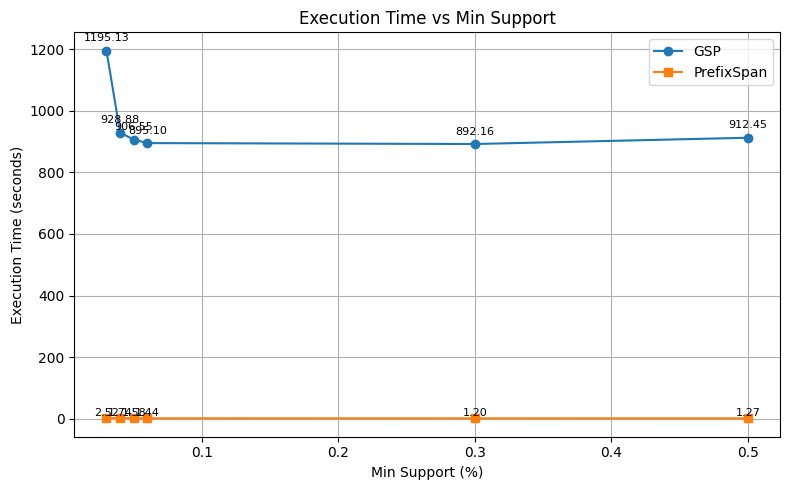

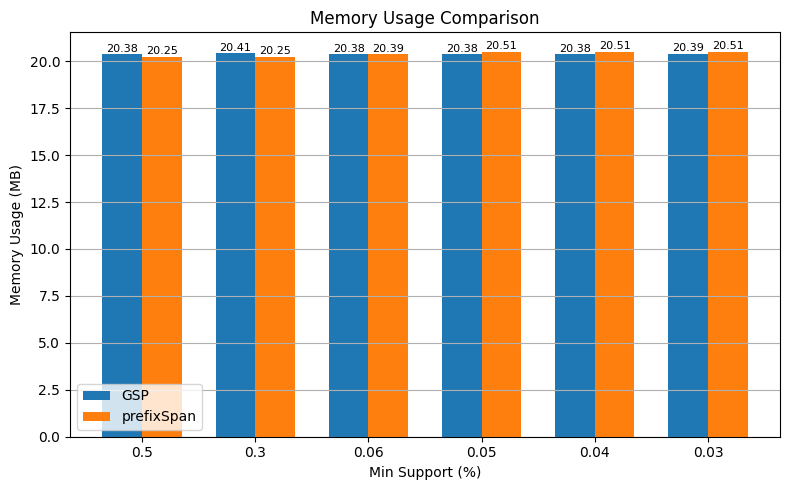

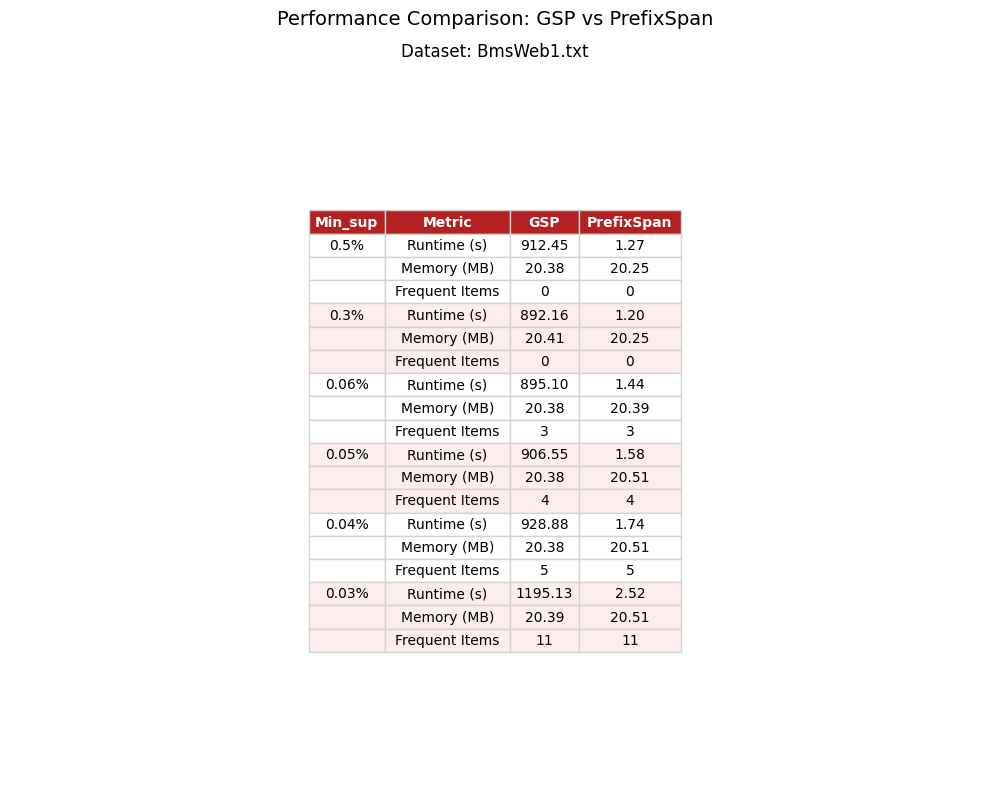

In [6]:
DATASET_DIR = "/home/faiak/Desktop/Academic/Data-Mining/Assignement_6/Datasets/"

datasets = {
    # "bike.txt": [0.3,0.25,0.2,0.15,0.1],
    # "eshop.txt": [0.9,0.8,0.6,0.5,0.4],
    # "sign.txt" : [0.8,0.7, 0.6, 0.5, 0.4, 0.3],
    "BmsWeb1.txt": [0.5, 0.3, 0.06, 0.05, 0.04, 0.03],
    
    # "book.txt": [0.5, 0.7],
}


import pyttsx3
engine = pyttsx3.init()
def finish_sound(message):

    # Set the text you want to speak
    text = message

    # Speak the text
    engine.say(text)

    # Wait for the speech to finish
    engine.runAndWait()
    # Or any .wav/.mp3 you have

import gc

def comparison():
    
    os.makedirs('./Output', exist_ok=True)
    output_file = './Output/output.log'
    sys.stdout = open(output_file, 'w')
    
    
    for file_name, min_sup_list in datasets.items():
        print(f"\n\n=======Processing dataset: {file_name}=======\n")
        
        gsp_times, prefixSpan_times = [], []
        gsp_mems, prefixSpan_mems = [], []
        gsp_freqs, prefixSpan_freqs = [], []
        
        
        for min_sup in min_sup_list:
            
            print(f"======= min_sup : {min_sup * 100}% ======= \n")
            
            file_path = DATASET_DIR + file_name
            
            
            # Run PrefixSpan
            prefixSpan_results, prefixSpan_total_sequences, prefixSpan_memory_usage, prefixSpan_execution_time = run_prefix_span(file_path, min_sup, max_length=100)
            prefixSpan_freqs.append(len(prefixSpan_results))
            prefixSpan_times.append(prefixSpan_execution_time)
            prefixSpan_mems.append(prefixSpan_memory_usage)
            
            print("PrefixSpan total sequences:", len(prefixSpan_results))
            print("PrefixSpan execution time:", prefixSpan_execution_time, "s")
            print("PrefixSpan memory usage:", prefixSpan_memory_usage, "MB")
            
            # Run GSP
            gsp_results, gsp_total_sequences, gsp_memory_usage, gsp_execution_time = run_gsp(file_path, min_sup)
            
            gsp_freqs.append(len(gsp_results))
            gsp_times.append(gsp_execution_time)
            gsp_mems.append(gsp_memory_usage)
            
            print("GSP total sequences:", len(gsp_results))
            print("GSP execution time:", gsp_execution_time, "s")
            print("GSP memory usage:", gsp_memory_usage, "MB")
            
            
            finish_sound(f"Processing complete for min_sup {min_sup * 100}% in {file_name}")
            print(f"Processing complete for min_sup {min_sup * 100}% in {file_name}")
            
            gc.collect()  # Force garbage collection to free memory
        
        
        plot_graphs(file_name, min_sup_list, gsp_times, prefixSpan_times, gsp_mems, prefixSpan_mems)
        generate_clean_table(file_name, min_sup_list, gsp_times, prefixSpan_times, gsp_mems, prefixSpan_mems, gsp_freqs, prefixSpan_freqs)
        
        finish_sound("Processing complete for " + file_name)
        print("Processing complete for " + file_name)
        
        

comparison()

finish_sound("All datasets processed successfully! Check the Output folder for results.")
print("All datasets processed successfully! Check the Output folder for results.")
        
    